In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf

2024-07-27 22:30:07.543474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 22:30:07.543578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 22:30:07.669798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print('GPU is ', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'not available')
print('Tensorflow version: ', tf.__version__)

GPU is  available
Tensorflow version:  2.15.0


# Load data

In [3]:
categories = ['chuyen-tham-kin', 'giao-duc', 'khoa-hoc-cong-nghe', 'lich-su', 'phat-trien-ban-than', 'quan-diem-tranh-luan', 'sach', 'tai-chinh', 'tam-ly-hoc', 'yeu']
# categories = ['chuyen-tham-kin', 'yeu']

df_list = []
for c in categories:
    tmp_df = pd.read_csv(f'/kaggle/input/2000-blogs-on-spiderum/{c}.csv')
    df_list.append(tmp_df)

df = pd.concat(df_list, ignore_index=True)
print(len(df))

2000


# Proprecessing texts

In [4]:
import re

def clean_text(texts):
    unwanted_patterns = [
        'spiderum.com', '=', '\xa0', '\n', '<', '>', '-', '_', '<3', '(', ')', ':', '*', '/', '@', '+'
    ]
    combined_pattern = '|'.join(map(re.escape, unwanted_patterns))
    
    cleaned_texts = re.sub(combined_pattern, ' ', texts)
    cleaned_texts = re.sub(r'\.{2,}', '.', cleaned_texts)
    cleaned_texts = re.sub(r'(?<=[a-zA-Z])([.!?])', r'\1 ', cleaned_texts)
    cleaned_texts = re.sub(r'\s+', ' ', cleaned_texts).strip()
    
    return cleaned_texts

df['content'] = df['content'].apply(clean_text)

# all_texts = " ".join(df.content)
# texts = clean_text(all_texts)

# len(texts.split())

In [5]:
df['content'][0][:1000]

'Một bài viết siêu mặn nói về một vấn đề siêu mặn. Từ một người viết siêu mặn. Cuộc cách mạng này đã, đang và sẽ tiếp tục diễn ra ở Việt Nam dù chúng ta muốn hay không. Bằng chứng mạnh mẽ nhất cho điều này chính và việc bạn bấm vào bài viết này của tôi và đọc đến dòng này. Cái váy sẽ còn ngắn hơn? Giới trẻ của chúng ta đã tiến được một bước xa hơn từ thời “cha ông chúng ta”. Khoảng cách xa này có thể tính ước lệ tượng hình bằng độ ngắn chiếc váy một cô nàng thời hiện đại so với độ dài của chiếc áo dài truyền thống thời bao cấp. Trong tương lai chiếc váy có ngắn hơn nhiều không thì vẫn chưa rõ. Nhưng có một điều giới trẻ chúng ta phải nhận thức được sau bài viết này cái váy đã, đang và sẽ ngắn hơn nữa. Tại sao lại như vậy? Hãy cùng tôi tìm hiểu qua bài viết siêu mặn này. Đọc thêm [18 ] FwB và ONS Cuộc chơi dành cho các dân tổ P1 Nếu không tiện đọc bài viết, bạn có thể nghe bản audio tại đây Từng có thâm niên nằm vùng các mặt trận Voz, Haivl,. 1, Xuất phát điểm. Mọi điều đều có nguồn cơn

# Prepare data

In [6]:
from tensorflow.keras.layers import TextVectorization
from tqdm import tqdm

class Dataset:
    def __init__(self):
        self.vectorizer = None

    def split_data(self, texts, ratio=0.9):
        n = int(ratio * len(texts))
        train_texts = texts[:n]
        val_texts = texts[n:]

        return train_texts, val_texts

    def build_tokenizer(self, texts, vocab_size):
        self.vectorizer = TextVectorization(
            max_tokens=vocab_size, 
            output_mode='int',
            standardize="lower_and_strip_punctuation",
            output_sequence_length=None
        )

        self.vectorizer.adapt(texts)

    def tokenize(self, texts):
        tokenized_texts = []
        for text in texts:
            tmp = self.vectorizer([text])[0].numpy()
            tokenized_texts.append(tmp)
            
        return tokenized_texts

    def create_seq_pair(self, texts, seq_len):
        input_sequences = []
        target_sequences = []

        for text in tqdm(texts):
            for i in range(len(text) - seq_len):
                input_seq = text[i:i + seq_len]
                target_seq = text[i + 1:i + seq_len + 1]
                input_sequences.append(input_seq)
                target_sequences.append(target_seq)

        input_seqs = np.array(input_sequences)
        target_seqs = np.array(target_sequences)

        return input_seqs, target_seqs

    def create_dataset(self, text_pair, batch_size=64):
        text_dataset = tf.data.Dataset.from_tensor_slices(text_pair)

        # Split data into batches
        text_dataset = text_dataset.batch(batch_size)
        # Shuffle and prefetch to increase performance
        text_dataset = text_dataset.shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)

        return text_dataset

    def prepare_data(self, texts, batch_size, seq_len, vocab_size):
        self.build_tokenizer(texts, vocab_size)

        vectorized_texts = self.tokenize(texts)
        vectorized_train_texts, vectorized_val_texts = self.split_data(vectorized_texts)

        train_inputs, train_targets = self.create_seq_pair(vectorized_train_texts, seq_len)
        val_inputs, val_targets = self.create_seq_pair(vectorized_val_texts, seq_len)

        train_ds = self.create_dataset((train_inputs, train_targets), batch_size)
        val_ds = self.create_dataset((val_inputs, val_targets), batch_size)

        return self.vectorizer.get_vocabulary(), train_ds, val_ds


In [7]:
vocab_size = 10000
num_layers = 6
d_model = 256
num_heads = 8
ff_dim = 1024
seq_len = 64
dropout_rate = 0.1
batch_size = 32

In [8]:
dataset = Dataset()

vocabulary, train_ds, val_ds = dataset.prepare_data(df.content.tolist(), batch_size, seq_len, vocab_size)

for x_batch, y_batch in train_ds.take(1):
    print(x_batch)
    print(y_batch)
    print('Train input batch size: ', x_batch.shape)
    print('Train target batch size: ', y_batch.shape)

100%|██████████| 200/200 [00:00<00:00, 247.26it/s]


tf.Tensor(
[[ 369 1217    4 ...  349   33  407]
 [1217    4 1476 ...   33  407  564]
 [   4 1476  163 ...  407  564 1515]
 ...
 [ 422    5  589 ...   14   30   39]
 [   5  589 1515 ...   30   39   27]
 [ 589 1515  891 ...   39   27  779]], shape=(32, 64), dtype=int64)
tf.Tensor(
[[1217    4 1476 ...   33  407  564]
 [   4 1476  163 ...  407  564 1515]
 [1476  163  200 ...  564 1515  891]
 ...
 [   5  589 1515 ...   30   39   27]
 [ 589 1515  891 ...   39   27  779]
 [1515  891   45 ...   27  779 1111]], shape=(32, 64), dtype=int64)
Train input batch size:  (32, 64)
Train target batch size:  (32, 64)


# Build Model

**Position encoding**

In [9]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size=10000, d_model=512, **kwargs):
        '''
        Args:
            seq_len: input length
            vocab size: input dim
            d_model: embedding vector size
        '''
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True)
        self.position_embeddings = self.positional_encoding(length=2048)

        
    def positional_encoding(self, n=10000, length=2048):
        assert self.d_model % 2 == 0
        d2 = self.d_model / 2
        
        position = np.arange(length)[:, np.newaxis]         # token position in sentence ~ [seq, 1]
        index = np.arange(d2)[np.newaxis, :]                # index position in embeded vector ~ [1, index]
        
        angle_rads = position * (np.power(n, -index / d2))   # p/(10000^(2i/d_model))
        
        pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
        
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        
        x = self.token_embeddings(inputs)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        pos_encoding = self.position_embeddings[tf.newaxis, :length, :]
        
        return x + pos_encoding
    
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)
    
    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "seq_len": self.seq_len,
            'vocab_size': self.vocab_size,
            'd_model': self.d_model
        })

In [10]:
embed = PositionalEmbedding(vocab_size, d_model)
inputs_emb = embed(x_batch)

print(inputs_emb.shape)   # (batch_size, seq_len, d_model)

(32, 64, 256)


**Multi-Headed Attention**

In [11]:
def shape_list(x):
    # Deal with dynamic shape in tensorflow cleanly.
    '''
    e.g: x = tf.placeholder(tf.float32, shape=[None, 128, None])
        => static_shape(x) = [None, 128, None]
           dynamic_shape(x) = [batch_size, 128, seq_len]
    -> Ensures that tensor operations work correctly regardless of whether the input shape changes or not.
    '''
    static_shape = x.shape.as_list()
    dynamic_shape = tf.shape(x)
    
    return [dynamic_shape[i] if s is None else s for i, s in enumerate(static_shape)]

# Causal masking
def attention_mask(target_len, source_len, dtype):
    i = tf.range(target_len)[:, None]      # (target_len, 1)
    j = tf.range(source_len)               # (1, source_len)
    m = i >= j - source_len + target_len   # m ~ (target_len, source_len)
    
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w ~ [batch_size, num_heads, target_sequence_length, source_sequence_length]
    # Information flows from source to target.
    _, _, target_len, source_len = shape_list(w)
    mask = attention_mask(target_len, source_len, dtype=w.dtype)
    mask = tf.reshape(mask, [1, 1, target_len, source_len])
    w = w * mask - tf.cast(1e10, w.dtype) * (1 - mask)
    
    return w

def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    '''
        q ~ [batch_size, num_heads, target_seq_len, head_dim]
        k ~ [batch_size, num_heads, source_seq_len, head_dim]
        v ~ [batch_size, num_heads, source_seq_len, head_dim]
    '''
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)   # size of vector k ~ head_dim
    scores = tf.matmul(q, k, transpose_b=True)   # Matmul of q and kT ~ [batch_size, num_heads, target_seq_len, source_seq_len]
    scaled_scores = scores / tf.math.sqrt(d_k)   # scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores)
    
    weights = tf.nn.softmax(scaled_scores, axis=-1)   # Softmax
    output = tf.matmul(weights, v)                    # Matmul of Softmax and v
    
    return output


In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
    '''
    input shape: [batch_size, seq_len, d_model]
    output shape: [batch_size, seq_len, d_model]
    '''
    def __init__(self, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        
        if d_model & num_heads != 0:
            raise ValueError(f"Dimension of the embedding space = {embed_dim} should be divisible by number of heads = {num_heads}")
        
        self.q_linear = tf.keras.layers.Dense(d_model)
        self.k_linear = tf.keras.layers.Dense(d_model)
        self.v_linear = tf.keras.layers.Dense(d_model)
        self.concat_linear = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        # x ~ (batch_size, seq_len, d_model)
        head_dim = self.d_model // self.num_heads
        x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, head_dim))  # -1 ~ Used to let TensorFlow automatically infer the remaining dimension so that the total number of elements does not change
        
        return tf.transpose(x, perm=[0, 2, 1, 3])  # ~ (batch_size, num_heads, seq_len, head_dim)
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.d_model))
                       
    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.q_linear(k)
        v = self.q_linear(v)
                       
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
                       
        return concat
    
    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "d_model": self.d_model,
            "h": self.num_heads,
        })
        return config

In [13]:
# Check input and output shape
mha = MultiHeadAttention(d_model, num_heads)

inputs_mha = inputs_emb

outputs_mha = mha(q=inputs_mha, k=inputs_mha, v=inputs_mha, use_causal_mask=True)

print('Inputs shape: ', inputs_mha.shape)
print('Outputs shape: ', outputs_mha.shape)

Inputs shape:  (32, 64, 256)
Outputs shape:  (32, 64, 256)


**Feed Forward**

In [14]:
class FeedForward(tf.keras.layers.Layer):
    '''
    input shape: [batch_size, seq_len, d_model]
    output shape: [batch_size, seq_len, d_model]
    '''
    def __init__(self, d_model, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        
        self.d_model = d_model
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.dense1 = tf.keras.layers.Dense(ff_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        
    def call(self, inputs):
        x = self.dense1(inputs)     # [batch_size, seq_len, ff_dim]
        x = self.dense2(x)          # [batch_size, seq_len, d_model]
        x = self.dropout(x)
        x = self.layer_norm(x + inputs)  # [batch_size, seq_len, d_model]
        
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        
        return config

In [15]:
# Check input and output shape
ff = FeedForward(d_model, ff_dim, dropout_rate)

inputs_ff = outputs_mha

outputs_ff = ff(inputs_ff)

print('Inputs shape: ', inputs_ff.shape)
print('Outputs shape: ', outputs_ff.shape)

Inputs shape:  (32, 64, 256)
Outputs shape:  (32, 64, 256)


**Decoder block**

In [16]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, d_model, ff_dim, num_heads, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        
        self.d_model = d_model
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.causal_self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.feed_forward = FeedForward(d_model, ff_dim, dropout_rate)
    
    def call(self, inputs):
        x = self.layer_norm_1(inputs + self.causal_self_attention(q=inputs, k=inputs, v=inputs, use_causal_mask=True))
        x = self.layer_norm_2(x + self.feed_forward(x))
                              
        return x

In [17]:
# Check input and output shape
decoder_layer = Decoder(d_model, ff_dim, num_heads, dropout_rate)

inputs_dec = outputs_ff

outputs_dec = decoder_layer(inputs_dec)

print('Inputs shape: ', inputs_dec.shape)
print('Outputs shape: ', outputs_dec.shape)

Inputs shape:  (32, 64, 256)
Outputs shape:  (32, 64, 256)


**Model**

In [18]:
class TextGenerationModel(tf.keras.Model):
    def __init__(self, *, 
    vocab_size: int,
    input_size: int=None,
    num_layers: int=6,
    d_model: int=512,
    num_heads: int=8,
    ff_dim: int=2048,
    seq_len: int=32,
    dropout_rate: float=0.1
):
        super().__init__()
        
        self.embed_input = PositionalEmbedding(vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.decoders = [Decoder(d_model, ff_dim, num_heads, dropout_rate) for _ in range(num_layers)]
        
        self.final_layer = tf.keras.layers.Dense(vocab_size)
    
    def call(self, inputs):
        x = self.embed_input(inputs)
        x = self.dropout(x)
        for layer in self.decoders:
            x = layer(x)
    
        logits = self.final_layer(x)
        
        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            del logits._keras_mask
        except AttributeError:
            pass
        
        return logits

In [19]:
vocab_size = 10000
num_layers = 6
d_model = 256
num_heads = 8
ff_dim = 1024
seq_len = 64
dropout_rate = 0.1
batch_size = 64

model = TextGenerationModel(vocab_size=vocab_size,
                           num_layers=num_layers,
                           d_model=d_model,
                           num_heads=num_heads,
                           ff_dim=ff_dim,
                           seq_len=seq_len,
                           dropout_rate=dropout_rate)

output = model(x_batch)
print(x_batch.shape)
print(output.shape)

model.summary()

(32, 64)
(32, 64, 10000)


Model: "text_generation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding_1          │ ?                      │     2,560,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │       658,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │       658,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Decoder)             │ ?                      │       658,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Decoder)             │ ?                      │       658,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_5 (Decoder)             │ ?                      │       658,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_6 (Decoder)             │ ?                      │       658,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,082,128 (34.65 MB)

 Trainable params: 9,082,128 (34.65 MB)

 Non-trainable params: 0 (0.00 B)

# Trainning model

**Set up optimizer**

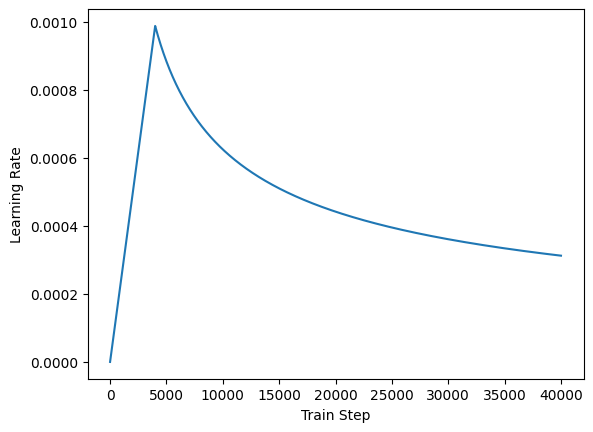

In [20]:
import matplotlib.pyplot as plt

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.d_model, tf.float32)
        
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * self.warmup_steps ** -1.5
        
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9,
)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [21]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [22]:
import os

checkpoint_filepath = '/kaggle/working/checkpoint/checkpoint.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
class EpochTrackerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global last_epoch
        last_epoch = epoch

epoch_tracker_callback = EpochTrackerCallback()

callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        save_freq='epoch'
    ),
    epoch_tracker_callback
]

In [23]:
EPOCHS = 3

model.compile(optimizer=optimizer, 
              loss=masked_loss,
              metrics=[masked_accuracy])

history = model.fit(train_ds, 
        epochs=EPOCHS, 
        callbacks=callbacks_list, 
        validation_data=val_ds)   

Epoch 1/3
     5/231207 ━━━━━━━━━━━━━━━━━━━━ 2:05:26 33ms/step - loss: 9.2139 - masked_accuracy: 2.2298e-04 

I0000 00:00:1722119530.691804      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722119530.728993      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


231206/231207 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.6750 - masked_accuracy: 0.1421

W0000 00:00:1722127007.891431      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


231207/231207 ━━━━━━━━━━━━━━━━━━━━ 7514s 32ms/step - loss: 5.6750 - masked_accuracy: 0.1421 - val_loss: 5.8011 - val_masked_accuracy: 0.1446 - learning_rate: 1.2998e-04
Epoch 2/3
231207/231207 ━━━━━━━━━━━━━━━━━━━━ 7508s 32ms/step - loss: 5.5329 - masked_accuracy: 0.1621 - val_loss: 5.8078 - val_masked_accuracy: 0.1477 - learning_rate: 9.1910e-05
Epoch 3/3
231207/231207 ━━━━━━━━━━━━━━━━━━━━ 7544s 33ms/step - loss: 5.5200 - masked_accuracy: 0.1648 - val_loss: 5.8148 - val_masked_accuracy: 0.1455 - learning_rate: 7.5045e-05


In [25]:
# model.load_weights(checkpoint_filepath)
# print(f"Training stopped at epoch {last_epoch + 1}")

# # Tiếp tục huấn luyện từ epoch đã dừng
# history = model.fit( 
#     train_ds,  
#     validation_data=val_ds,
#     epochs=9,  
#     initial_epoch=last_epoch + 1, 
#     callbacks=callbacks_list
# )

<Axes: >

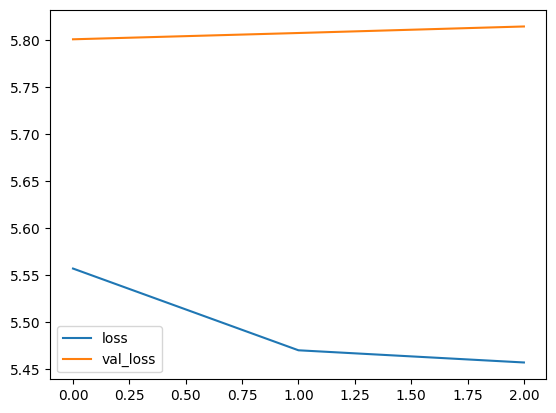

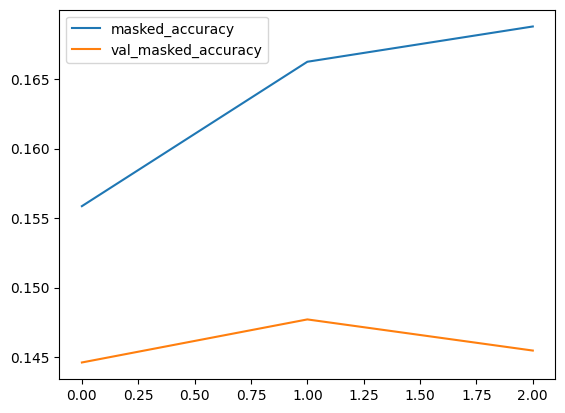

In [26]:
metrics_df = pd.DataFrame(history.history) 
metrics_df[["loss", "val_loss"]].plot()
metrics_df[["masked_accuracy", "val_masked_accuracy"]].plot()

In [36]:
model.load_weights(checkpoint_filepath)

class Generator(tf.Module):
    def __init__(
        self,
        tokenizer,
        vocabulary,
        model,
        max_new_tokens,
        temperature=0.0,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.vocabulary = vocabulary
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature
    
    def decode_sentence(self, texts):
        decoded_sentences = []
        for sentence in texts[0]:
            if sentence != b'':
                decoded_sentences.append(sentence.decode('utf-8'))

        return ' '.join(decoded_sentences)

    def __call__(self, sentence, max_length=seq_len):
        sentence = self.tokenizer(sentence)
        sentence = tf.expand_dims(sentence, axis=0)
        encoder_input = sentence
        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

        print(f"Generating {self.max_new_tokens} tokens")
        for i in tf.range(self.max_new_tokens):
            output = tf.transpose(output_array.stack())
            predictions = self.model(encoder_input, training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            if self.temperature == 0.0:
                # greedy sampling, output always the same
                predicted_id = tf.argmax(predictions, axis=-1)
            else:
                predictions = predictions / self.temperature
                predicted_id = tf.random.categorical(predictions[0], num_samples=1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i + 1, predicted_id[0])
            encoder_input = tf.experimental.numpy.append(encoder_input, predicted_id[0])
            encoder_input = tf.expand_dims(encoder_input, axis=0)

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        id_to_word = tf.keras.layers.StringLookup(
            vocabulary=self.vocabulary, mask_token="", oov_token="[UNK]", invert=True
        )

        print(f"Using temperature of {self.temperature}")
        text = tf.constant(id_to_word(output)).numpy()
        
        text = self.decode_sentence(text)
        
        tokens = output

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.model(output[:, :-1], training=False)

        return text, tokens

In [37]:
max_new_tokens = 50
temperature = 0.9
generator = Generator(
    dataset.vectorizer, vocabulary, model, max_new_tokens, temperature, 
)

In [38]:
sentence = 'tôi thích'
generated_text, generated_tokens = generator(sentence)

print(sentence + ' ' + generated_text)

Generating 50 tokens
Using temperature of 0.9
tôi thích người nhưng tôi đã từng nói rằng mình có một báo kiến thức tôi ở đây thật là nguồn văn nghèo vì điều gì em đều được định nghĩa gì con chỉ nghĩ đến còn để cảm xúc khi thực ra mà họ có nghĩa là người yêu và người
